### Curso cientista de dados - Projeto final

Sobre o projeto: Uma empresa de empréstimos sofre com a inadimpência de seus clientes e o nosso objetivo é reduzir essa taxa.

Criar um modelo de machine learning a partir de um banco de dados
Jonathan de Oliveira 
 *https://www.linkedin.com/in/jonathan-deoliveira/*
*https://github.com/jhowxd1*


In [50]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import tensorflow as tf
from yellowbrick.classifier import ConfusionMatrix 
import psycopg2

In [17]:
#conexão com o banco de dados
conexao = psycopg2.connect(host="localhost",database="Projeto", user="postgres", password="12345", port=5432)

In [18]:
#cria um cursor
cursor = conexao.cursor()
#define consulta
consulta = "select * from credito"
#executa
cursor.execute(consulta)

In [19]:
#recupera todos os registros
registros = cursor.fetchall()

In [ ]:
#percorre os registros e imprime
for registro in registros:
    print(registro)

In [21]:
# a variavel registro nos vem como uma tupla, então transformamos em array usando o numpy
db = pd.DataFrame(np.array(registros))
db.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,48,2,1,5951,2,3,2,1,3,2,22,3,1,1,4,1,0,0,0
1,3,12,1,2,2096,2,4,2,4,3,3,49,3,1,1,3,2,0,0,1
2,4,42,2,3,7882,2,4,2,4,4,4,45,3,2,1,4,2,0,0,1
3,5,24,3,4,4870,2,3,3,4,3,4,53,3,2,2,4,2,0,0,0
4,6,36,2,2,9055,1,3,2,4,3,4,35,3,2,1,3,2,1,0,1


In [22]:
#Damos nomes para as colunas através do comando columns do pandas
db.columns = ["IDCREDITO", "Duracao", "HistoricoCredito", "Proposito", "Valor", "Investimentos", "Emprego", "TempoParcelamento", "EstadoCivil", 
              "FiadorTerceiros", "ResidenciaDesde", "Idade", "OutrosFinanciamentos", "Habitacao", "EmprestimoExistente", "Profissao", 
              "Dependentes", "SocioEmpresa", "Estrangeiro", "Status"]

In [23]:
#verificamos o formato do banco de dados para ver se está ok e podemos começar a explorar os dados
db.shape

(1000, 20)

In [24]:
#Verificar se existem valores nulos(NaN) na database
db.isnull().sum()

IDCREDITO                0
Duracao                  0
HistoricoCredito         0
Proposito                0
Valor                    0
Investimentos            0
Emprego                 10
TempoParcelamento        0
EstadoCivil              0
FiadorTerceiros          0
ResidenciaDesde          7
Idade                    0
OutrosFinanciamentos     0
Habitacao                9
EmprestimoExistente      0
Profissao                0
Dependentes              0
SocioEmpresa             0
Estrangeiro              0
Status                   0
dtype: int64

In [25]:
#A coluna emprego possui um valor NaN, mas como não é um  valor numérico, utilizamos a Moda
#Repetimos o processo para as colunas ResidenciaDesde e Habitacao
emprego = db.groupby(['Emprego']).size()
emprego

Emprego
1    171
2    247
3    338
4    172
5     62
dtype: int64

In [26]:
#Subistituir o valor NaN pela moda
db['Emprego'].fillna(3, inplace = True)

In [27]:
#Repetimos o processo para a coluna ResidenciaDesde
residencia = db.groupby(['ResidenciaDesde']).size()
residencia

ResidenciaDesde
1    129
2    308
3    147
4    409
dtype: int64

In [28]:
#Subistituir o valor NaN pela moda
db['ResidenciaDesde'].fillna(4, inplace = True)

In [29]:
#Repetimos o processo para a coluna Habitacao
habitacao = db.groupby(['Habitacao']).size()
habitacao

Habitacao
1    709
2    107
3    175
dtype: int64

In [30]:
#Subistituir o valor NaN pela moda
db['Habitacao'].fillna(1, inplace = True)

In [31]:
#Repetimos o processo para a coluna Profissao, pois analizando o banco de dados descobrimos um valor não nulo, porém fora dos padrões
profissao = db.groupby(['Profissao']).size()
profissao

Profissao
1      147
2       22
3      197
4      625
999      9
dtype: int64

In [32]:
#Como o valor 999 não é nulo, precisamos localizá-lo na tabela e substituílo pela moda.
db.loc[(db['Profissao'] > 5 ), 'Profissao'] = 4

In [33]:
profissao = db.groupby(['Profissao']).size()
profissao

Profissao
1    147
2     22
3    197
4    634
dtype: int64

In [34]:
db.head()

,IDCREDITO,Duracao,HistoricoCredito,Proposito,Valor,Investimentos,Emprego,TempoParcelamento,EstadoCivil,FiadorTerceiros,ResidenciaDesde,Idade,OutrosFinanciamentos,Habitacao,EmprestimoExistente,Profissao,Dependentes,SocioEmpresa,Estrangeiro,Status
0,2,48,2,1,5951,2,3,2,1,3,2,22,3,1,1,4,1,0,0,0
1,3,12,1,2,2096,2,4,2,4,3,3,49,3,1,1,3,2,0,0,1
2,4,42,2,3,7882,2,4,2,4,4,4,45,3,2,1,4,2,0,0,1
3,5,24,3,4,4870,2,3,3,4,3,4,53,3,2,2,4,2,0,0,0
4,6,36,2,2,9055,1,3,2,4,3,4,35,3,2,1,3,2,1,0,1


In [35]:
x= db.iloc[:,0:19].values #previsores
y= db.iloc[:,19].values #classe

In [36]:
LE = LabelEncoder()
scaler = StandardScaler()

In [37]:
for z in range(19):
    x[:,z] = LE.fit_transform(x[:,z])
x.shape

(1000, 19)

In [38]:
y = LE.fit_transform(y)

In [39]:
# Divisão da base em treino e teste (70% para treinamento e 30% para teste)
x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(x, y, 
                                                                  test_size=0.3,
                                                                  random_state=0)

In [41]:
# Criação e treinamento do modelo (geração da tabela de probabilidades)
naive_bayes = GaussianNB()
naive_bayes.fit(x_treinamento, y_treinamento)

GaussianNB()

In [42]:
# Previsões utilizando os registros de teste
previsoes = naive_bayes.predict(x_teste)
previsoes

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1])

In [43]:
#geração da matriz de confusão e cálculo da taxa de acerto e erro
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[ 44,  31],
       [ 62, 163]], dtype=int64)

In [44]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
taxa_acerto

0.69

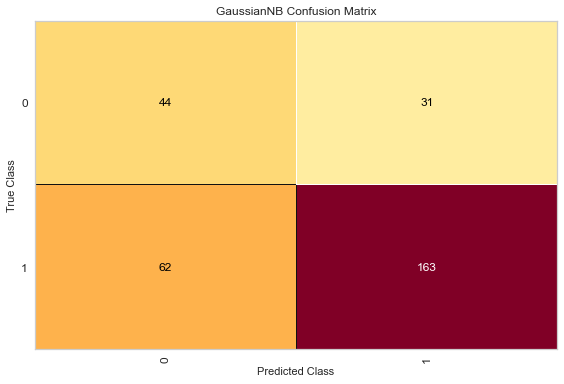

<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [51]:
# Visualização da matriz de confusão
# Warning interno da biblioteca yellowbrick, já esta na última versão (sem solução para o warning no momento)
v = ConfusionMatrix(GaussianNB())
v.fit(x_treinamento, y_treinamento)
v.score(x_teste, y_teste)
v.poof()